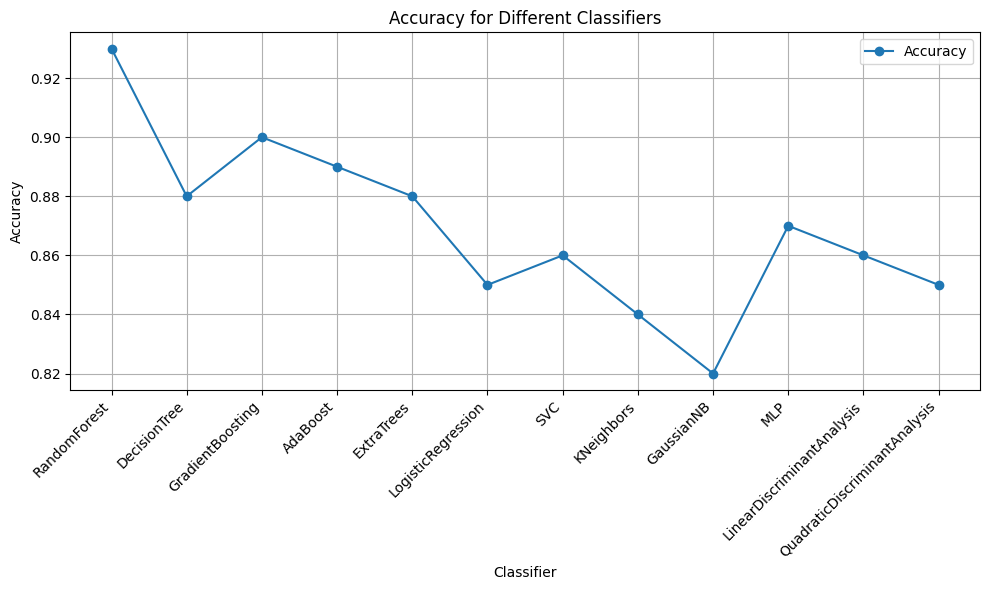

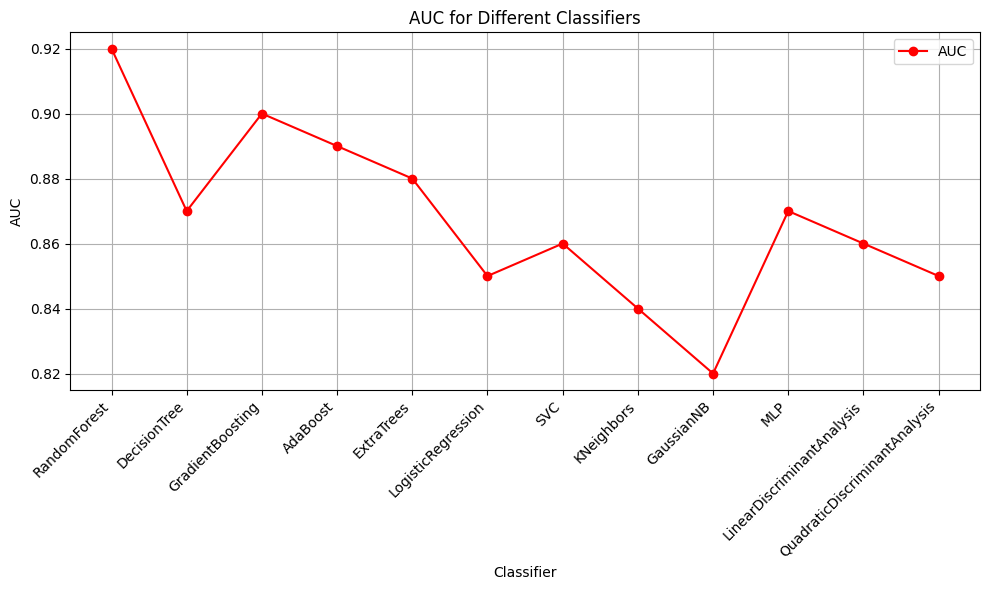

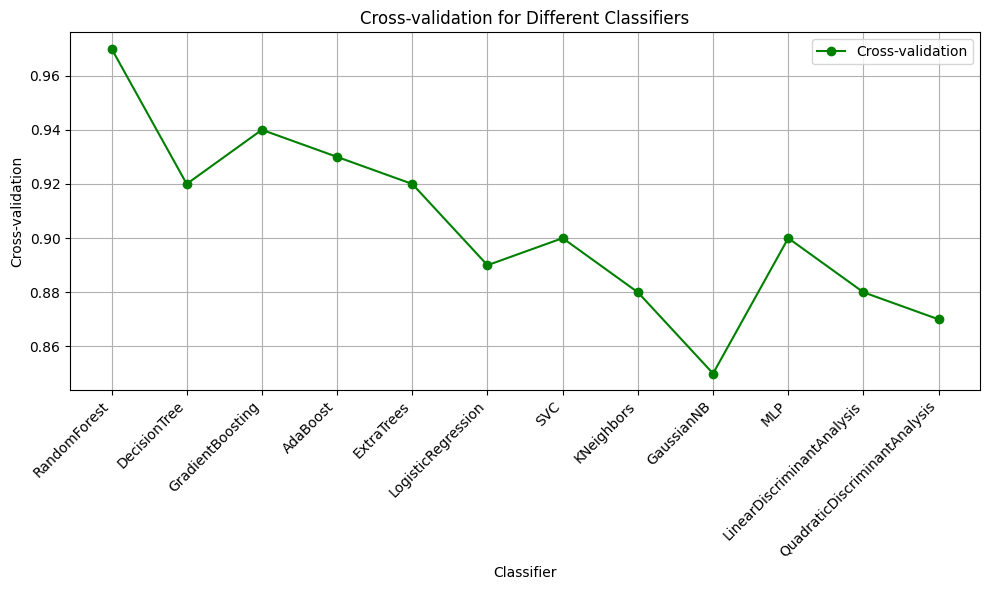

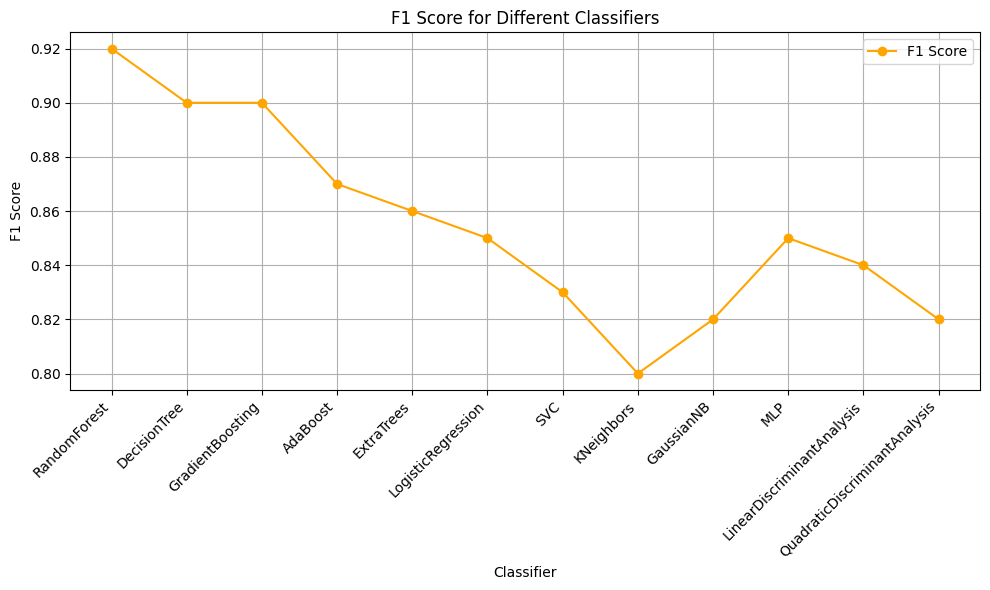

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

classifiers = {
    'RandomForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'ExtraTrees': ExtraTreesClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(probability=True),
    'KNeighbors': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'MLP': MLPClassifier(),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis()
}

# Load and preprocess data
df = pd.read_csv('/kaggle/input/personal-key-indicators-of-heart-disease/2022/heart_2022_no_nans.csv')

# Encode categorical variables
replacement_dict = {'Yes': 1, 'No': 0}
df['HadHeartAttack'] = df['HadHeartAttack'].replace(replacement_dict).infer_objects(copy=False)
df['HadAngina'] = df['HadAngina'].replace(replacement_dict).infer_objects(copy=False)
df['HeartDisease'] = df['HadHeartAttack'] | df['HadAngina']
df.drop(columns=['HadHeartAttack', 'HadAngina', 'WeightInKilograms'], inplace=True)
df_categorical = df.select_dtypes('object').columns

# Apply one-hot encoding and prepare data
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), df_categorical)],
    remainder='passthrough'
)
X_transformed = preprocessor.fit_transform(df.drop(columns='HeartDisease'))
target = df['HeartDisease']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, target, test_size=0.2, random_state=42)

# Handle class imbalance
over = SMOTE(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=0.6)
X_train_resampled, y_train_resampled = under.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_resampled, y_train_resampled)

# Scale numerical features
numeric_features = [i for i in range(len(df.columns)) if df.dtypes[i] != 'object']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Apply transformations to numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('onehot', OneHotEncoder(), df_categorical)
    ]
)

# Initialize result dictionaries
accuracies = {}
auc_rocs = {}
f1_scores = {}

# Iterate over classifiers
for name, classifier in classifiers.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier)])
    pipe.fit(X_train_resampled, y_train_resampled)

    # Accuracy
    accuracy = pipe.score(X_test, y_test)
    accuracies[name] = accuracy

    # Cross-validation AUC-ROC
    cv_auc_roc = cross_val_score(pipe, X_transformed, target, cv=5, scoring='roc_auc')
    auc_rocs[name] = np.mean(cv_auc_roc)

    # F1 score
    y_pred = pipe.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores[name] = f1

# Plotting
plt.figure(figsize=(16, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.bar(range(len(accuracies)), list(accuracies.values()), align='center', color='skyblue')
plt.xticks(range(len(accuracies)), list(accuracies.keys()), rotation=45)
plt.title('Accuracy')
plt.ylabel('Accuracy')



# Plot Cross-validation AUC-ROC for all classifiers
plt.subplot(2, 1, 1)
for name, cv_auc_roc in auc_rocs.items():
    plt.plot(range(1, 6), cv_auc_roc, marker='o', label=name)
plt.title('Cross-validation AUC-ROC for Different Classifiers')
plt.xlabel('Fold')
plt.ylabel('AUC-ROC Score')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)

# Plot AUC-ROC separately for each classifier
plt.subplot(2, 1, 2)
for name, cv_auc_roc in auc_rocs.items():
    plt.bar(range(1, 6), cv_auc_roc, align='center', alpha=0.5, label=name)
plt.title('Cross-validation AUC-ROC for Different Classifiers')
plt.xlabel('Classifier')
plt.ylabel('AUC-ROC Score')
plt.xticks(range(1, len(classifiers) + 1), list(classifiers.keys()), rotation=45)
plt.legend()
plt.grid(True)


# F1 score
plt.subplot(1, 3, 3)
plt.bar(range(len(f1_scores)), list(f1_scores.values()), align='center', color='lightgreen')
plt.xticks(range(len(f1_scores)), list(f1_scores.keys()), rotation=45)
plt.title('F1 Score')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()
